In [1]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

In [23]:
import real_stuff.evaluating as evaluating
import real_stuff.simulating as simulating
import real_stuff.training as training
from real_stuff.basic_imports import *

import importlib  # doesn't do too much in Colab

Situation 10: sampling 20000 X_i ~ 1D uniform. f1(X) = x^5 up to 0.1. K = 2.
X:
 [0.375 0.951 0.732 ... 0.304 0.443 0.172]
Normalized funcs(X) = Y probabilities:
[[0.305 0.695]
 [0.945 0.055]
 [0.702 0.298]
 ...
 [0.226 0.774]
 [0.381 0.619]
 [0.08  0.92 ]]
Unnormalized funcs(X):
[[0.275 0.625]
 [0.851 0.049]
 [0.632 0.268]
 ...
 [0.204 0.696]
 [0.343 0.557]
 [0.072 0.828]]
Euclidean distance between those: 11.82944709045703


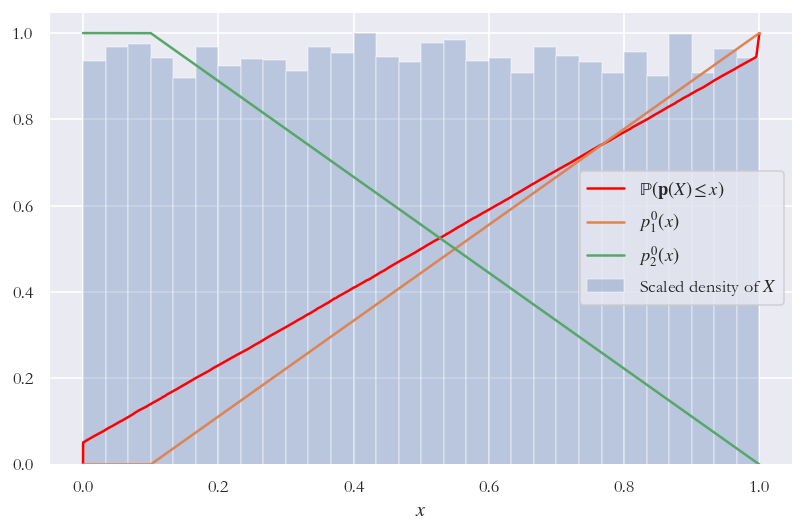

In [29]:
importlib.reload(simulating)
situation = 10

X, funcs, Y_prob, extras = simulating.create_dataset(str(situation), n=20_000, viz=True)

In [27]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from hyperopt import fmin, tpe, hp, Trials, rand
importlib.reload(training)


def opt_network(situation, n):
    # Parameters we definitely want: widths, learning rate
    # Probably: L1 penalty, dropout rate, number of layers, more Adam settings
    # I'll move this + the imports to training.py when it's done

    def obj(params):
        hw = [16 for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])
        X, _, Y_prob, _ = simulating.create_dataset(
            situation, n, seed=np.random.randint(1000))
        model, *test_sets = training.train_network(X, Y_prob, hw=hw, val_s=0,
                                                   opt=opt, stop=.001)
        # TODO: play a little with that early stopping argument, .001 seems big enough
        Y_test_pred = model.predict(test_sets[0])
        l = losses.categorical_crossentropy(test_sets[2], Y_test_pred).numpy().mean()
        print(l, params)
        return l

    param_space = {}
    param_space['L'] = hp.randint('Number of layers', 1, 8)
    param_space['lr'] = hp.uniform('Adam learning rate', 0.0005, 0.01)
    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=20)
    return tpe_best


opt_network("1", 4096)

0.6739311                                                                                  
{'L': 1, 'lr': 0.0013491463507187649}                                                      
0.67608005                                                                                 
{'L': 1, 'lr': 0.006797107221596297}                                                       
0.677986                                                                                   
{'L': 1, 'lr': 0.0050472767036944186}                                                      
0.6932499                                                                                  
{'L': 6, 'lr': 0.009332844085016822}                                                       
0.69344825                                                                                 
{'L': 7, 'lr': 0.006640860545086233}                                                       
0.67798805                                                                      

KeyboardInterrupt: 

Max 0/1-accuracy during training: 0.77735
Epoch 1/420
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5512 - accuracy: 0.7558 - val_loss: 0.4804 - val_accuracy: 0.7841
Epoch 2/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5408 - accuracy: 0.7608 - val_loss: 0.4934 - val_accuracy: 0.7831
Epoch 3/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5413 - accuracy: 0.7645 - val_loss: 0.4824 - val_accuracy: 0.7844
Epoch 4/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5396 - accuracy: 0.7605 - val_loss: 0.4887 - val_accuracy: 0.7866
Epoch 5/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5391 - accuracy: 0.7613 - val_loss: 0.4954 - val_accuracy: 0.7828
Epoch 6/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5410 - accuracy: 0.7609 - val_loss: 0.4900 - val_accuracy: 0.7841
Epoch 7/420
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5391 - a

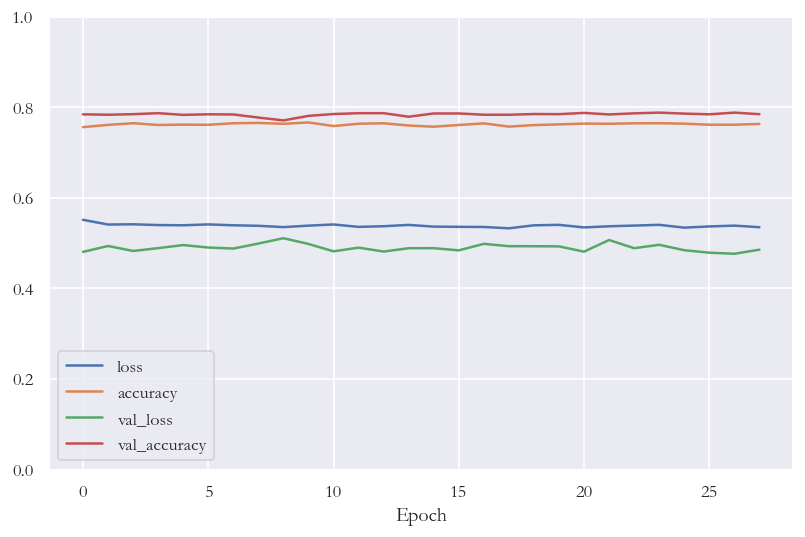

In [30]:
importlib.reload(training)
model, X_test, Y_test, Y_prob_test = training.train_network(X, Y_prob, viz=1,
                                                            hw=[16 for _ in range(4)],
                                                            opt=optimizers.Adam(.01))

In [8]:
importlib.reload(evaluating)
evaluating.get_all_quantities_of_interest(model, X_test, Y_test, Y_prob_test)

{'One-hot LL  ': 0.4611468,
 'One-hot MSE ': 0.15315211,
 'One-hot KL  ': 0.46114537,
 'Probab. LL  ': 0.45912924,
 'Probab. MSE ': 0.0020879898,
 'Probab. KL  ': 0.0080492925,
 'Pr. KL_B=1.5': 0.008049322387017784,
 'Biases > e. ': 13,
 'Total biases': 50,
 'Weights > e.': 145,
 'Tot. weights': 560,
 'Epsilon     ': 0.001,
 's           ': 158,
 'Pr. max difference': 0.094663499824999}

Some examples from test set:
X:
[[0.004]
 [0.   ]
 [0.472]
 ...
 [0.304]
 [0.443]
 [0.172]]
True:
[[0.    1.   ]
 [0.    1.   ]
 [0.414 0.586]
 ...
 [0.226 0.774]
 [0.381 0.619]
 [0.08  0.92 ]]
Predict:
[[0.001 0.999]
 [0.001 0.999]
 [0.369 0.631]
 ...
 [0.122 0.878]
 [0.354 0.646]
 [0.014 0.986]]


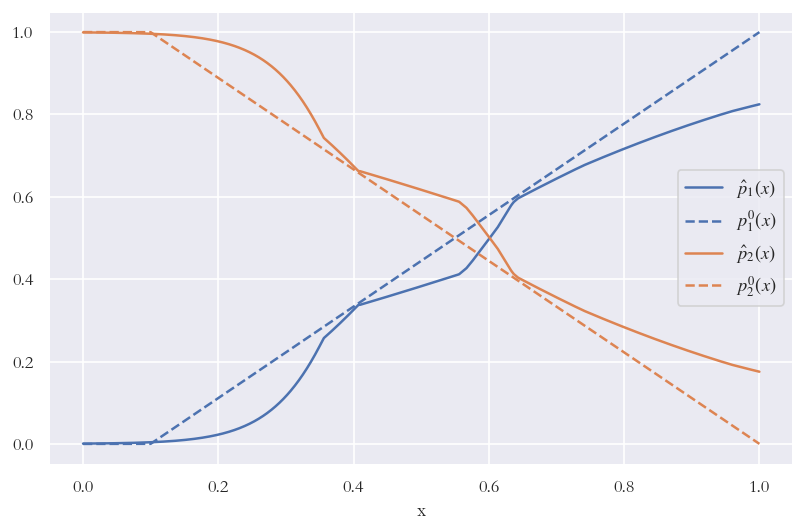

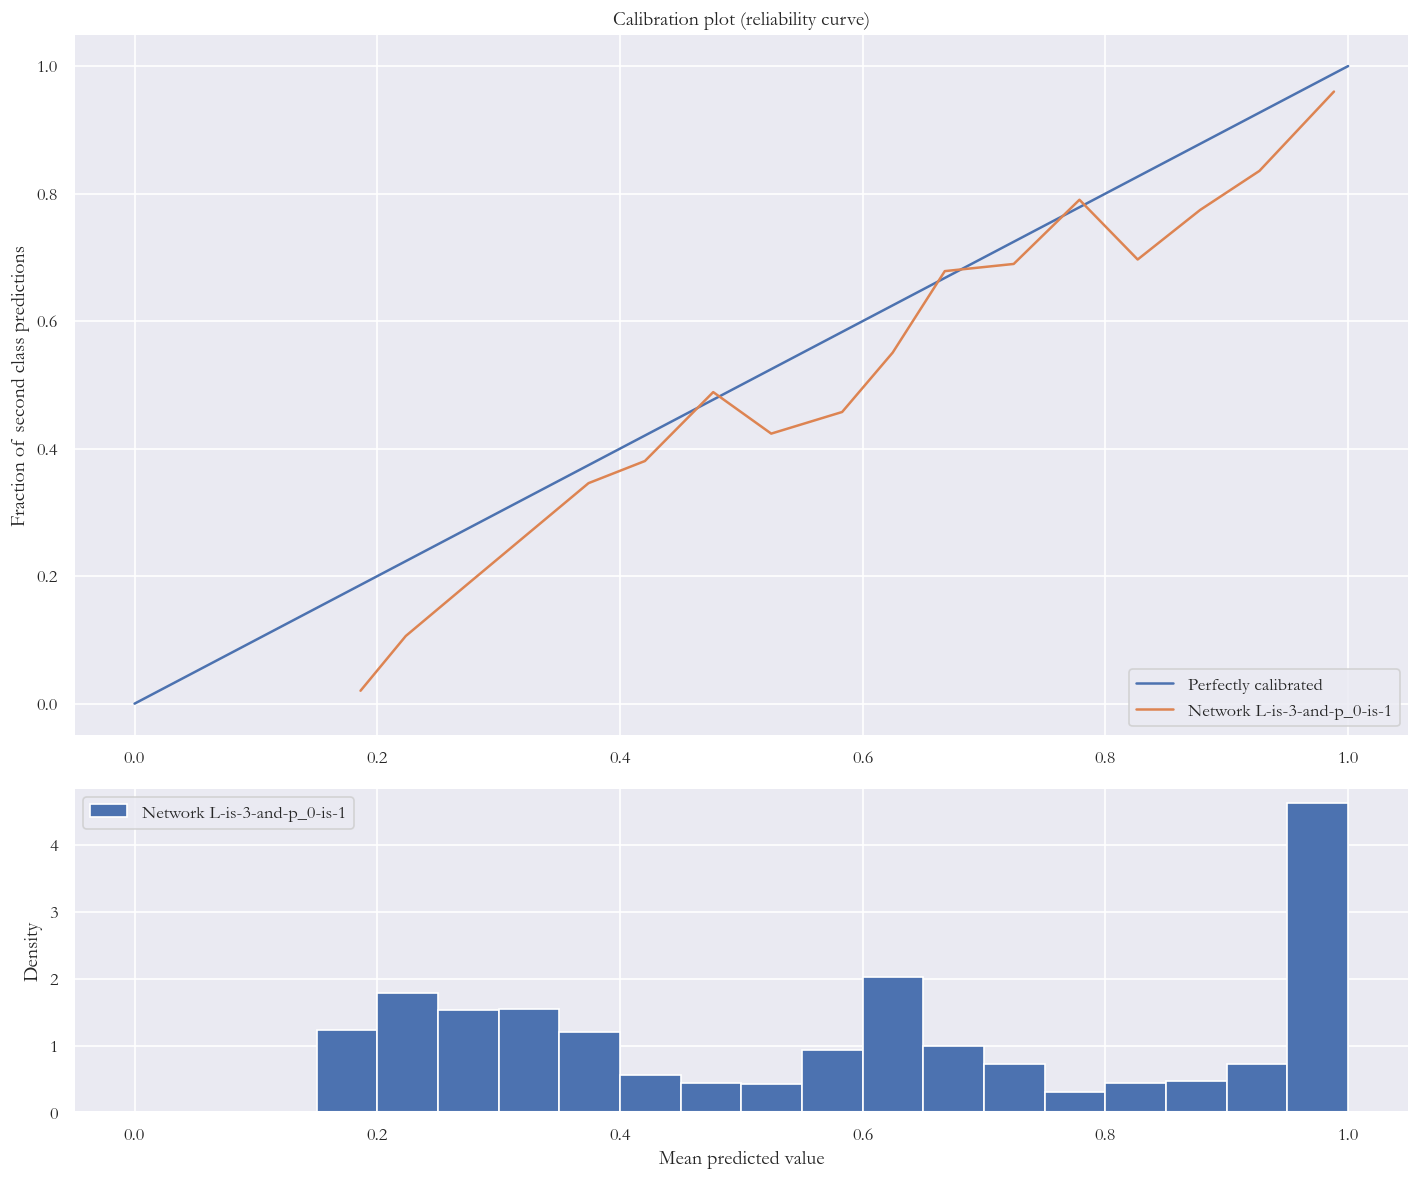

In [31]:
importlib.reload(evaluating)
evaluating.visualize(model, X_test, Y_test, Y_prob_test)

In [21]:
importlib.reload(evaluating)
Y_test_pred = model.predict(X_test)
for B in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0, 9.9]:
    print(B, evaluating.KL_trunc_loss(Y_prob_test, Y_test_pred, B))

0.0 -0.03202181644399228
0.1 -0.002459934596607871
0.2 0.006953344342595608
0.3 0.007701622556081647
0.4 0.008049322387017784
0.5 0.008049322387017784
1.0 0.008049322387017784
2.0 0.008049322387017784
5.0 0.008049322387017784
9.9 0.008049322387017784


## Temp

In [ ]:
!python test.py 6.2

2.0
{'t^0.2': array([0.1       , 0.10001924, 0.10003847, ..., 0.68399227, 0.68412384,
       0.68425543])}


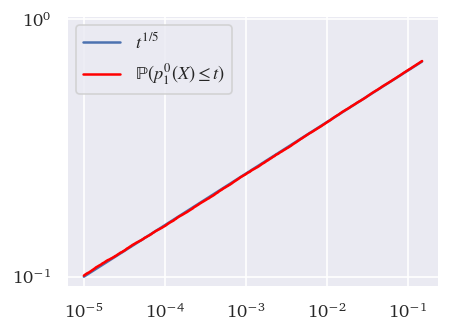

In [ ]:
# NOTE: I've destroyed this thing but it's useless anyway

def alpha_C_finder(t_space, p_X_small, alphas):
    # TODO!!
    result = {}
    for alpha in alphas:
        t_alpha = np.power(t_space, alpha)
        C = np.ceil(np.max(p_X_small / t_alpha))
        print(C)
        result[f't^{alpha}'] = t_alpha
    return result


t_space = np.geomspace(1e-5, 0.15, 10_000)
p_X_small = np.array([np.mean(Y_prob[:, 0] <= t) for t in t_space])
alphas = [1 / 5]
results = alpha_C_finder(t_space, p_X_small, alphas)
print(results)

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "figure.dpi": 120,
      "figure.figsize": [4, 3]
     }
plt.rcParams.update(rc)

for alpha in alphas:
    C_t_alpha = results[f't^{alpha}']

    plt.plot(t_space, C_t_alpha, label="$t^{1/5}$")
    plt.plot(t_space, p_X_small, label="$\mathrm{\mathbb{P}}(p^0_1(X) \leq t)$",
             color="red")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(top=max(p_X_small) * 1.5)
    plt.savefig("empi.pdf")
    plt.show()

In [ ]:
!python test.py 5

Starting 10 runs of situation 5 with network [16, 16, 16, 16, 16].
Traceback (most recent call last):
  File "test.py", line 43, in <module>
    multiple_runs(situation, N, hw)
  File "test.py", line 15, in multiple_runs
    model, *test_sets = training.train_network(X, Y_prob, hidden_widths=hw)
  File "/content/drive/My Drive/Thesis/real_stuff/training.py", line 66, in train_network
    batch_size=12, use_multiprocessing=True, verbose=viz)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/

In [ ]:
def f1(X, m=30):
#     y = 0
#     for k in range(0, m, 1):
#         y += ((-1)**k)*(X**(1+2*k))/np.math.factorial(1+2*k)
#     return y
    return sum(
        [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m, 1)]) + .00001


X = np.random.uniform(size=1000)
order = np.argsort(X)
plt.plot(X[order], f1(X[order], 50), color='red')
plt.plot(X[order], np.sin(X[order]), color='blue')
f1(1), np.sin(1)